In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, matthews_corrcoef, auc, log_loss
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()
eng_stopwords = set(stopwords.words("english"))

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
%matplotlib inline
pd.set_option('display.max_columns',None)

In [2]:
df = pd.read_csv('fake_job_postings.csv')

In [3]:
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


## Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [5]:
df = df.fillna(value='-')

In [6]:
df = df.drop(columns='salary_range')

In [7]:
APPO = {
"aren't" : "are not",
"can't" : "can not",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "i would",
"i'd" : "i had",
"i'll" : "i will",
"i'm" : "i am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "i have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
'doesnt' : 'does not'
}

In [8]:
def clean(comment):

    comment=comment.lower()
    comment = re.sub(r'\\n','',comment)
    comment = re.sub(r'wikipedia:.*#[\.\S]+[a-z]', '', comment)
    comment = re.sub(r'http[\.\S]+[\.\S]', '', comment)
    comment = re.sub(r'[0-9\.\:]*[0-9]', '', comment)
    comment = re.sub(r'file:.*jpg', '', comment)
    comment = re.sub(r'\.gif', '', comment)
    comment = re.sub(r'\[\[user(.*)\|', '', comment)
    comment = re.sub(r'www[\.\S]+[\.\S]','', comment)
    comment = re.sub(r'http', '', comment)
    comment = re.sub(r'\.', ' ', comment)
    
    # add wikipedia to reduce size
    comment = re.sub(r'wikipedia', '', comment)
    
    #Split the sentences into words
    words = tokenizer.tokenize(comment)
    
    whitelist = ["not", "no"]
    words = [APPO[word] if word in APPO else word for word in words]
    words = [lem.lemmatize(word, "v") for word in words]
    words = [word.split() for word in words]
    words = [item for sublist in words for item in sublist]
    words = [char for char in words if char not in string.punctuation]
    words = [word for word in words if (word not in eng_stopwords or word in whitelist) and len(word) > 1]
    words = [lem.lemmatize(word, "v") for word in words]
    
    clean_sent=" ".join(words)
    
    b = re.findall("[\'\sa-zA-Z]", clean_sent)
    clean_sent = ''.join(b)
    return(clean_sent)

In [9]:
df['company_profile'] = df['company_profile'].apply(clean)
df['description'] = df['description'].apply(clean)
df['requirements'] = df['requirements'].apply(clean)
df['benefits'] = df['benefits'].apply(clean)

In [10]:
df = df.drop(columns=['job_id','title','department'
])

In [11]:
df.head()

,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,"US, NY, New York",food create groundbreaking awardwinning cook s...,food fastgrowing jam beard awardwinning online...,experience content management systems major pl...,,0,1,0,Other,Internship,-,-,Marketing,0
1,"NZ, , Auckland",second worlds cloud video production service s...,organise focus vibrant awesome passion custome...,expect key responsibility communicate client s...,get usthrough part second team gain experience...,0,1,0,Full-time,Not Applicable,-,Marketing and Advertising,Customer Service,0
2,"US, IA, Wever",valor service provide workforce solutions meet...,client locate houston actively seek experience...,implement precommissioning commission procedur...,,0,1,0,-,-,-,-,-,0
3,"US, DC, Washington",passion improve quality life geography heart e...,company esri environmental systems research in...,education bachelor master gi business administ...,culture anything corporate collaborative creat...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,"US, FL, Fort Worth",spotsource solutions llc global human capital ...,job title itemization review managerlocation f...,qualifications rn license state texasdiploma b...,full benefit offer,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [12]:
def get_location(df):
    x = df.split(', ')
    return x[0]

In [13]:
df['location'] = df['location'].apply(get_location)

In [14]:
df

,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,US,food create groundbreaking awardwinning cook s...,food fastgrowing jam beard awardwinning online...,experience content management systems major pl...,,0,1,0,Other,Internship,-,-,Marketing,0
1,NZ,second worlds cloud video production service s...,organise focus vibrant awesome passion custome...,expect key responsibility communicate client s...,get usthrough part second team gain experience...,0,1,0,Full-time,Not Applicable,-,Marketing and Advertising,Customer Service,0
2,US,valor service provide workforce solutions meet...,client locate houston actively seek experience...,implement precommissioning commission procedur...,,0,1,0,-,-,-,-,-,0
3,US,passion improve quality life geography heart e...,company esri environmental systems research in...,education bachelor master gi business administ...,culture anything corporate collaborative creat...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,US,spotsource solutions llc global human capital ...,job title itemization review managerlocation f...,qualifications rn license state texasdiploma b...,full benefit offer,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,CA,vend look awesome new talent come join us work...,case first time visit website vend award win w...,ace role eat comprehensive statements work bre...,expect us open culture openly share result inp...,0,1,1,Full-time,Mid-Senior level,-,Computer Software,Sales,0
17876,US,weblinc ecommerce platform service provider fa...,payroll accountant focus primarily payroll fun...,account desire fun love genuine passion accoun...,health wellnessmedical planprescription drug p...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,US,provide full time permanent position many medi...,experience project cost control staff engineer...,least years professional experience ability wo...,,0,0,0,Full-time,-,-,-,-,0
17878,NG,,nemsia studios look experience visual graphic ...,must fluent latest versions corel adobe cc esp...,competitive salary compensation base experienc...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [15]:
df['telecommuting'].value_counts()

0    17113
1      767
Name: telecommuting, dtype: int64

In [16]:
df['has_company_logo'].value_counts()

1    14220
0     3660
Name: has_company_logo, dtype: int64

In [17]:
df['has_questions'].value_counts()

0    9088
1    8792
Name: has_questions, dtype: int64

In [18]:
df['employment_type'].value_counts()

Full-time    11620
-             3471
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: employment_type, dtype: int64

In [19]:
df['employment_type'] = df['employment_type'].replace({'-':'Other'})

In [20]:
df['required_experience'].value_counts()

-                   7050
Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: required_experience, dtype: int64

In [21]:
df['required_experience'] = df['required_experience'].replace({'-':'Not Applicable'})

In [22]:
df['required_education'].value_counts()

-                                    8105
Bachelor's Degree                    5145
High School or equivalent            2080
Unspecified                          1397
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: required_education, dtype: int64

In [23]:
df['required_education'] = df['required_education'].replace({'-':'Unspecified'})

In [24]:
df['industry'].value_counts()

-                                      4903
Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
                                       ... 
Shipbuilding                              1
Wine and Spirits                          1
Museums and Institutions                  1
Ranching                                  1
Alternative Dispute Resolution            1
Name: industry, Length: 132, dtype: int64

In [25]:
df['industry'] = df['industry'].replace({'-':'Other'})

In [26]:
df['function'].value_counts()

-                         6455
Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Administrative             630
Design                     340
Health Care Provider       338
Education                  325
Other                      325
Management                 317
Business Development       228
Accounting/Auditing        212
Human Resources            205
Project Management         183
Finance                    172
Consulting                 144
Art/Creative               132
Writing/Editing            132
Production                 116
Product Management         114
Quality Assurance          111
Advertising                 90
Business Analyst            84
Data Analyst                82
Public Relations            76
Manufacturing               74
General Business            68
Research                    50
Legal                       47
Strategy/Planning           46
Training

In [27]:
df['function'] = df['function'].replace({'-':'Other'})

In [28]:
df['company_profile'] = df['company_profile'].replace({'':'None'})
df['description'] = df['description'].replace({'':'None'})
df['requirements'] = df['requirements'].replace({'':'None'})
df['benefits'] = df['benefits'].replace({'':'None'})

In [29]:
df.head()

,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,US,food create groundbreaking awardwinning cook s...,food fastgrowing jam beard awardwinning online...,experience content management systems major pl...,None,0,1,0,Other,Internship,Unspecified,Other,Marketing,0
1,NZ,second worlds cloud video production service s...,organise focus vibrant awesome passion custome...,expect key responsibility communicate client s...,get usthrough part second team gain experience...,0,1,0,Full-time,Not Applicable,Unspecified,Marketing and Advertising,Customer Service,0
2,US,valor service provide workforce solutions meet...,client locate houston actively seek experience...,implement precommissioning commission procedur...,None,0,1,0,Other,Not Applicable,Unspecified,Other,Other,0
3,US,passion improve quality life geography heart e...,company esri environmental systems research in...,education bachelor master gi business administ...,culture anything corporate collaborative creat...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,US,spotsource solutions llc global human capital ...,job title itemization review managerlocation f...,qualifications rn license state texasdiploma b...,full benefit offer,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## EDA

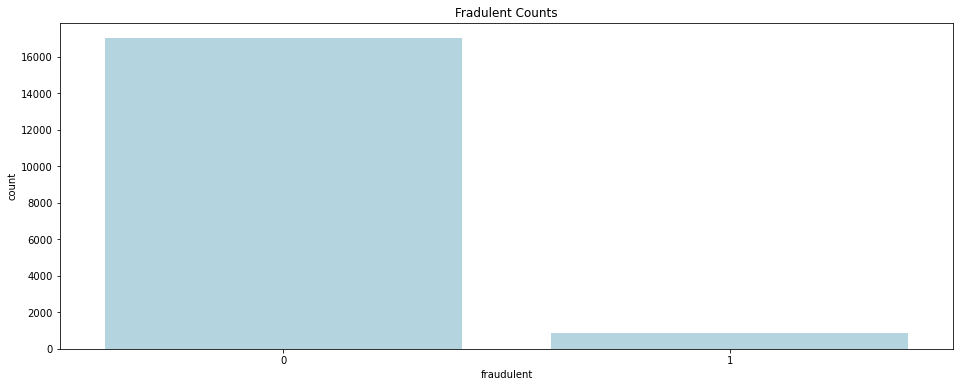

In [30]:
plt.figure(figsize=(16,6))
sns.countplot(df['fraudulent'],color='lightblue')
plt.title('Fradulent Counts')
plt.show()

Target Variable is unbalanced. We will get to that later.

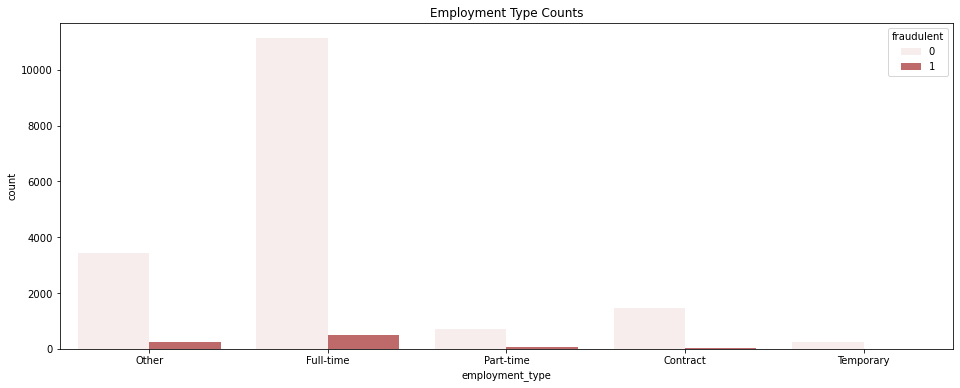

In [31]:
plt.figure(figsize=(16,6))
sns.countplot(df['employment_type'],hue=df['fraudulent'],color='indianred')
plt.title('Employment Type Counts')
plt.show()

Full time employment gives most fraudulent job, maybe because Full-time gives the most counts.

<ipython-input-32-f53e3c6f32b4>:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.bar(c.keys(),c.values,color='rgb')


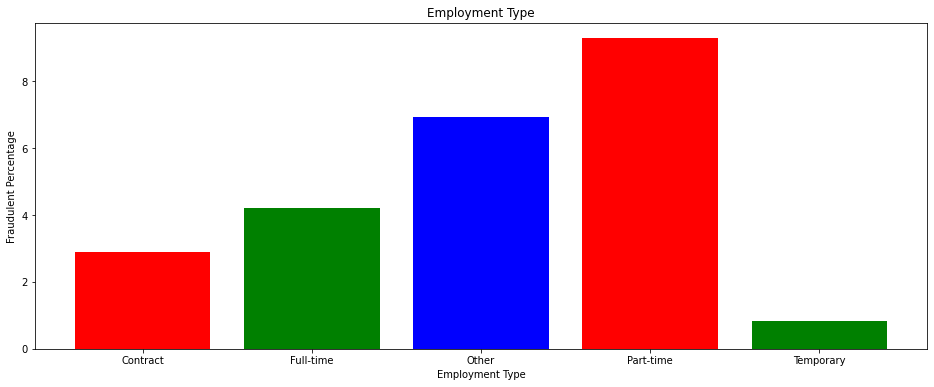

In [32]:
a = df[df['fraudulent']==1]['employment_type'].value_counts()
b = df['employment_type'].value_counts()
c = a/b*100

plt.figure(figsize=(16,6))
plt.bar(c.keys(),c.values,color='rgb')
plt.title('Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Fraudulent Percentage')
plt.show()

Part time job posting have the highest fraudulent type.

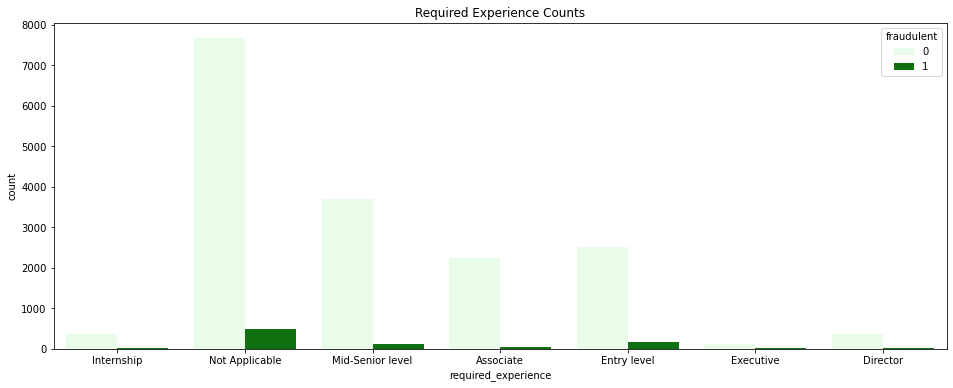

In [33]:
plt.figure(figsize=(16,6))
sns.countplot(df['required_experience'],hue=df['fraudulent'],color='green')
plt.title('Required Experience Counts')
plt.show()

<ipython-input-34-aa7c26e80f7e>:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.bar(c.keys(),c.values,color='rgb')


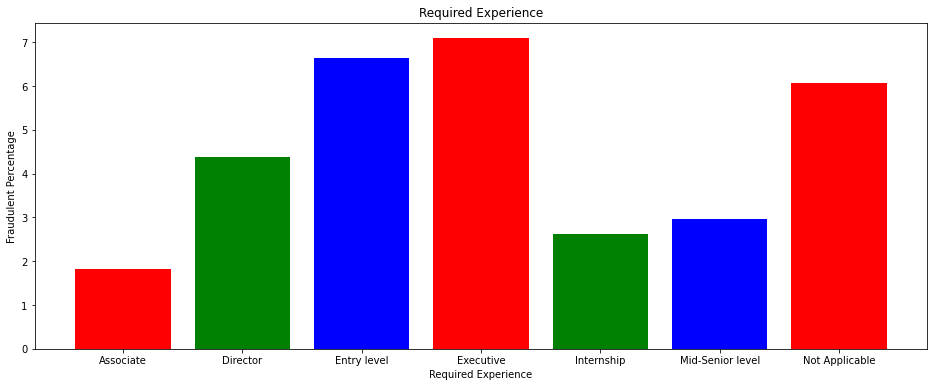

In [34]:
a = df[df['fraudulent']==1]['required_experience'].value_counts()
b = df['required_experience'].value_counts()
c = a/b*100

plt.figure(figsize=(16,6))
plt.bar(c.keys(),c.values,color='rgb')
plt.title('Required Experience')
plt.xlabel('Required Experience')
plt.ylabel('Fraudulent Percentage')
plt.show()

Excecutive experience required have the highest percentage of fraudulent job post.

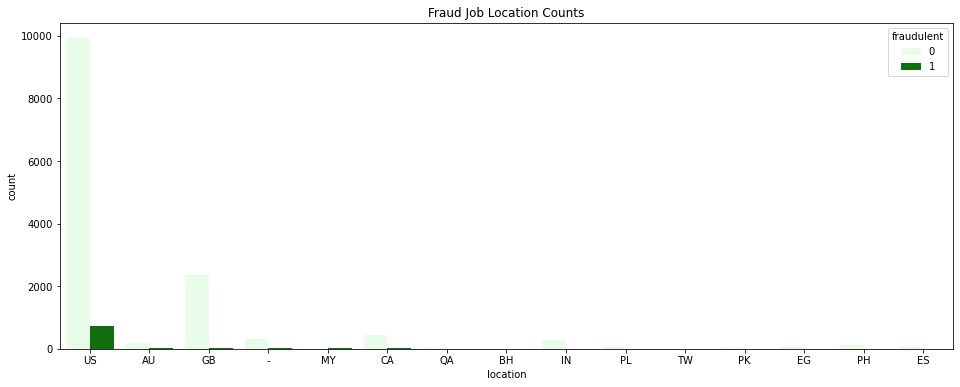

In [35]:
plt.figure(figsize=(16,6))
sns.countplot(df['location'],hue=df['fraudulent'],color='green',order=df[df['fraudulent']==1]['location'].value_counts()[:15].index)
plt.title('Fraud Job Location Counts')
plt.show()

Most of the fraud job postings come from US

In [36]:
req = df[df['fraudulent']==1]['requirements']
benef = df[df['fraudulent']==1]['benefits']

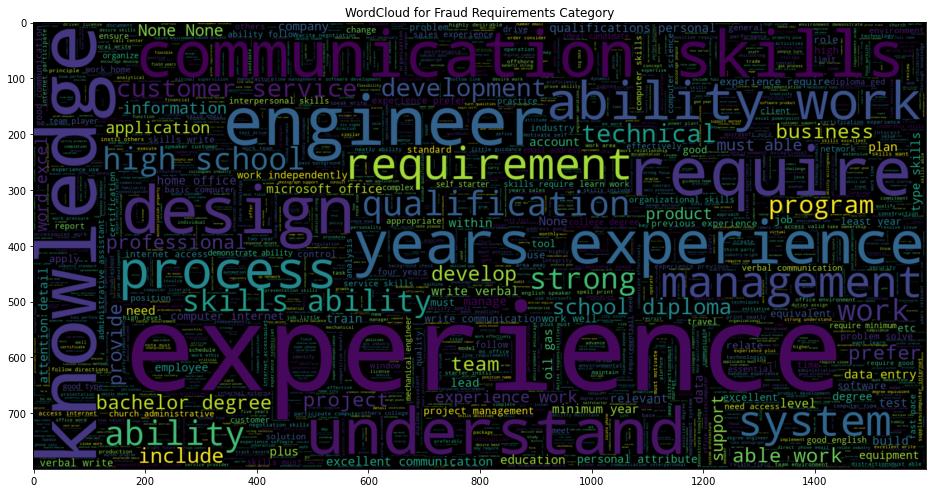

In [37]:
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 ,
               stopwords = STOPWORDS).generate(str(" ".join(req)))
plt.imshow(wc,interpolation = 'bilinear')
plt.title('WordCloud for Fraud Requirements Category')
plt.show()

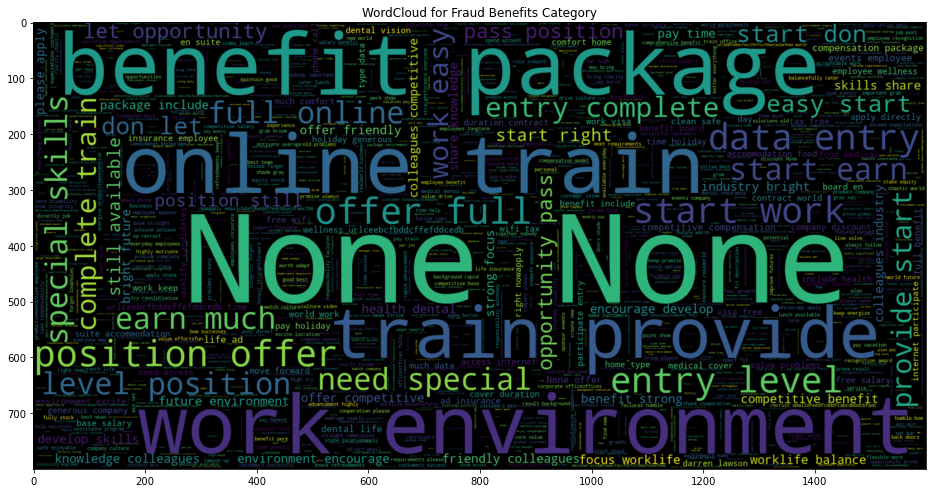

In [38]:
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 ,
               stopwords = STOPWORDS).generate(str(" ".join(benef)))
plt.imshow(wc,interpolation = 'bilinear')
plt.title('WordCloud for Fraud Benefits Category')
plt.show()

Most of fraud job post didn't post their working benefits.

## Data Splitting

In [39]:
df.head()

,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,US,food create groundbreaking awardwinning cook s...,food fastgrowing jam beard awardwinning online...,experience content management systems major pl...,None,0,1,0,Other,Internship,Unspecified,Other,Marketing,0
1,NZ,second worlds cloud video production service s...,organise focus vibrant awesome passion custome...,expect key responsibility communicate client s...,get usthrough part second team gain experience...,0,1,0,Full-time,Not Applicable,Unspecified,Marketing and Advertising,Customer Service,0
2,US,valor service provide workforce solutions meet...,client locate houston actively seek experience...,implement precommissioning commission procedur...,None,0,1,0,Other,Not Applicable,Unspecified,Other,Other,0
3,US,passion improve quality life geography heart e...,company esri environmental systems research in...,education bachelor master gi business administ...,culture anything corporate collaborative creat...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,US,spotsource solutions llc global human capital ...,job title itemization review managerlocation f...,qualifications rn license state texasdiploma b...,full benefit offer,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [40]:
X = df.drop(columns='fraudulent')
y = df['fraudulent']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14304, 13), (3576, 13), (14304,), (3576,))

In [42]:
y_test.value_counts()

0    3403
1     173
Name: fraudulent, dtype: int64

In [43]:
y_train.value_counts()

0    13611
1      693
Name: fraudulent, dtype: int64

In [44]:
X_train

,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
7530,US,tidewater finance co establish initial purpose...,tidewater finance company locate virginia beac...,position require follow qualifications minimum...,company offer competitive salary plus bonuses ...,0,1,0,Full-time,Entry level,Unspecified,Financial Services,Customer Service
129,US,novitex enterprise solutions formerly pitney b...,customer service associate base dallas tx righ...,qualificationsminimum year customer service re...,None,0,1,0,Full-time,Entry level,High School or equivalent,Telecommunications,Customer Service
4640,NZ,silverstripe cms framework open source platfor...,look dedicate passionate software test analyst...,None,None,0,1,1,Full-time,Mid-Senior level,Unspecified,Information Technology and Services,Other
402,US,abc supply co inc nation largest wholesale dis...,sales representative provide assistance custom...,sales representative must ability provide supe...,benefit package sales representative may inclu...,0,1,0,Full-time,Not Applicable,Unspecified,Building Materials,Sales
13218,US,meundies lifestyle brand transform way people ...,meundies lifestyle brand transform way people ...,requirements qualifications personal attribute...,meundies fastgrowing vcbacked company laser fo...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Marketing
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841,US,happyfox young startup bring happiness quotien...,happyfox young web saas startup bring happines...,years experience relevant pr prove track recor...,competitive paycasual creative work environment,0,1,1,Contract,Associate,Bachelor's Degree,Information Technology and Services,Public Relations
11852,GR,tizu free iphone app allow send hide message f...,tizu mobile app allow send hide message friend...,years ios developmenthave publish least one or...,not fund not offer salary yet establish connec...,0,1,1,Other,Not Applicable,Unspecified,Other,Other
10870,US,investment professionals locate throughout uni...,top real estate investment broker seek full ti...,require skills excel microsoft office comforta...,None,0,1,0,Full-time,Entry level,High School or equivalent,Real Estate,Other
565,US,novitex enterprise solutions formerly pitney b...,customer service associate base phoenix az rig...,minimum requirements minimum months customer s...,None,0,1,0,Full-time,Entry level,High School or equivalent,Legal Services,Administrative


In [45]:
preprocessor = ColumnTransformer([('words1', CountVectorizer(),'company_profile'),
                                  ('words2', CountVectorizer(),'description'),
                                  ('words3', CountVectorizer(),'requirements'),
                                  ('words4', CountVectorizer(),'benefits'),
    ('categoric1', cat_pipe(encoder='onehot'), ['location','employment_type','required_experience','required_education',
                                              'industry','function'])    
])

In [46]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 18.1min finished


{'algo__max_depth': 63, 'algo__max_features': 0.9446974381141753, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 163}
0.9672619047619048 0.8742138364779876
Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.96      0.80      0.87       173

    accuracy                           0.99      3576
   macro avg       0.97      0.90      0.93      3576
weighted avg       0.99      0.99      0.99      3576



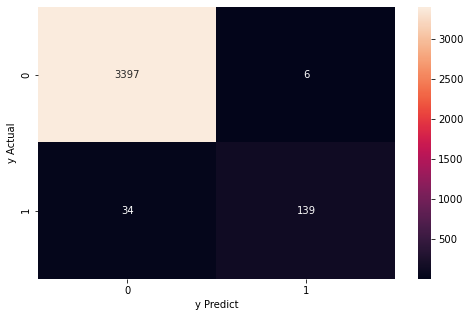

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model1 = RandomizedSearchCV(pipeline, rsp.rf_params, cv=4, scoring='f1', n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model1.fit(X_train, y_train)

print(model1.best_params_)
print(model1.score(X_train, y_train), model1.score(X_test, y_test))

y_pred1 = model1.predict(X_test)

print('Classification Report')
print(classification_report(y_test, y_pred1))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred1), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Predict")
plt.ylabel("y Actual")
plt.show()

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.3min finished


{'algo__colsample_bytree': 0.4370861069626263, 'algo__gamma': 8, 'algo__learning_rate': 0.1575132049977973, 'algo__max_depth': 7, 'algo__n_estimators': 182, 'algo__reg_alpha': 0.0025113061677390002, 'algo__reg_lambda': 0.06870614282613305, 'algo__subsample': 0.4668543055695109}
0.8661290322580645 0.8040540540540541
Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.97      0.69      0.80       173

    accuracy                           0.98      3576
   macro avg       0.98      0.84      0.90      3576
weighted avg       0.98      0.98      0.98      3576



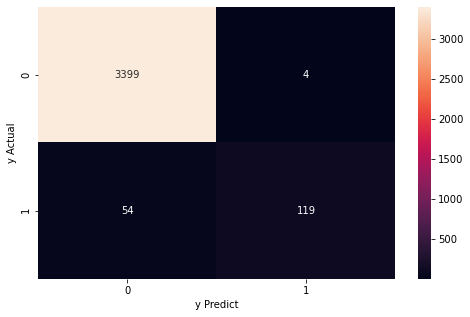

In [48]:
from xgboost import XGBClassifier
pipeline1 = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model2 = RandomizedSearchCV(pipeline1, rsp.xgb_params, cv=4, scoring='f1', n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model2.fit(X_train, y_train)

print(model2.best_params_)
print(model2.score(X_train, y_train), model2.score(X_test, y_test))

y_pred2 = model2.predict(X_test)

print('Classification Report')
print(classification_report(y_test, y_pred2))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Predict")
plt.ylabel("y Actual")
plt.show()

## Feature Importance using Mean Score Decrease

,feature,importance,stdev
1,company_profile,0.771235,0.023515
2,description,0.290274,0.003538
3,requirements,0.072434,0.001794
11,industry,0.053948,0.004218
12,function,0.051931,0.002043
4,benefits,0.035399,0.001188
9,required_experience,0.031383,0.002749
0,location,0.004764,0.000572
8,employment_type,0.003349,0.000599
10,required_education,0.000431,0.000352


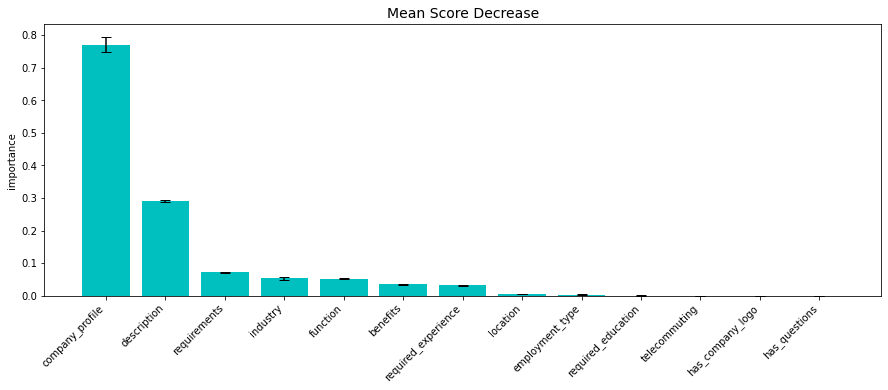

In [49]:
mean_score_decrease(X_train, y_train, model1, plot=True)

In [50]:
X1 = df[['company_profile','description','requirements']]
y = df['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14304, 3), (3576, 3), (14304,), (3576,))

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 16.4min finished


{'algo__max_depth': 63, 'algo__max_features': 0.9446974381141753, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 163}
0.9610194902548725 0.842443729903537
Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.95      0.76      0.84       173

    accuracy                           0.99      3576
   macro avg       0.97      0.88      0.92      3576
weighted avg       0.99      0.99      0.99      3576



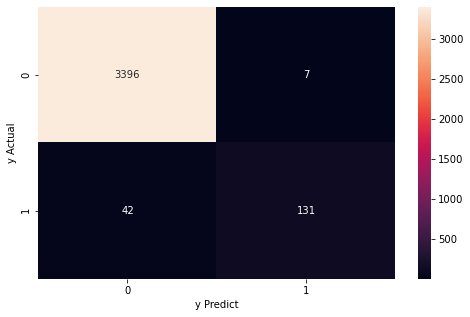

In [51]:
preprocessor1 = ColumnTransformer([('words1', CountVectorizer(),'company_profile'),
                                  ('words2', CountVectorizer(),'description'),
                                  ('words3', CountVectorizer(),'requirements')
                                
        
])

pipeline1 = Pipeline([
    ('prep', preprocessor1),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model3 = RandomizedSearchCV(pipeline1, rsp.rf_params, cv=4, scoring='f1', n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model3.fit(X_train, y_train)

print(model3.best_params_)
print(model3.score(X_train, y_train), model3.score(X_test, y_test))

y_pred3 = model3.predict(X_test)

print('Classification Report')
print(classification_report(y_test, y_pred3))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred3), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Predict")
plt.ylabel("y Actual")
plt.show()

We get 0.96 for the train score and 0.84 for the test score. The goal is to find the closest score possible to prevent overfit. There are many ways to achieve, one of them is by manually set the model parameter.

In [52]:
preprocessor1 = ColumnTransformer([('words1', CountVectorizer(),'company_profile'),
                                  ('words2', CountVectorizer(),'description'),
                                  ('words3', CountVectorizer(),'requirements')  
])

0.8545454545454546 0.822742474916388
Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.98      0.71      0.82       173

    accuracy                           0.99      3576
   macro avg       0.98      0.86      0.91      3576
weighted avg       0.99      0.99      0.98      3576



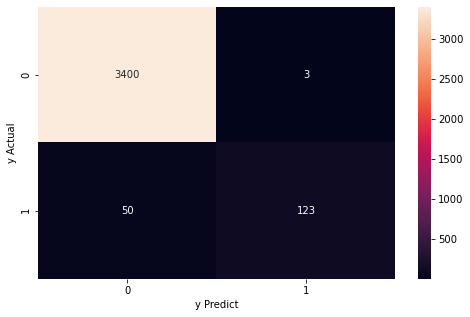

In [53]:
pipeline2 = Pipeline([
    ('prep', preprocessor1),
    ('algo', RandomForestClassifier(max_depth= 20,
     max_features= 0.7,
     min_samples_leaf= 2, 
     n_estimators= 130))
])
model4 = pipeline2.fit(X_train, y_train)
y_preda = model4.predict(X_train)
y_pred4 = model4.predict(X_test)

print(f1_score(y_train, y_preda), f1_score(y_test, y_pred4))

print('Classification Report')
print(classification_report(y_test, y_pred4))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred4), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Predict")
plt.ylabel("y Actual")
plt.show()

Now we get 0.85 and 0.83 score test.